In [6]:
import random
random.seed(12)

# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

from skimage import io

import math
import pickle

# from pytorch_metric_learning import losses, miners, distances, reducers, testers
# from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import os

## Visualization

In [7]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

# label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
label_dict = {
    0: 'Surprise',
    1: 'Fear',
    2: 'Disgust',
    3: 'Happiness',
    4: 'Sadness',
    5: 'Anger',
    6: 'Neutral',
}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, (tsne_features, str_labels)


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

## Define RAFDB dataset

In [8]:
class RAFDBDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, annos, images_path, transforms, train_set=True, aligned=False):
        'Initialization'
        self.transforms = transforms
        self.images_path = images_path
        self.aligned = aligned
        self.annos = open(annos, 'r').read().split('\n')[:-1] if type(annos) is str else annos[:-1]

        data_type = 'train' if train_set is True else 'test'
        self.annos = [k for k in self.annos if data_type in k]
        self.ids = [k.split(' ')[0] for k in self.annos]
        self.labels = [k.split(' ')[1] for k in self.annos]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.annos)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        if self.aligned:
            X = io.imread(os.path.join(self.images_path, self.ids[index].split('.')[0] + '_aligned' + '.' + self.ids[index].split('.')[1]))
        else:
            X = io.imread(os.path.join(self.images_path, self.ids[index]))
        y = int(self.labels[index]) - 1

        if self.transforms:
            # X = self.transforms(image=X)['image']
            X = self.transforms(X)

        return X, y

## Aligned

In [28]:
annos = "../../../data/benchmark_datasets/emotion/rafdb/list_patition_label.txt"
images_path = "../../../data/benchmark_datasets/emotion/rafdb/aligned/"

batch_size = 64

# train_transforms = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# Normalize the test set same as training set without augmentation
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = RAFDBDataset(annos, images_path, test_transforms, True, True)
test_set = RAFDBDataset(annos, images_path, test_transforms, False, True)

train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=batch_size, shuffle=True,
                                             num_workers=8)

test_loader = torch.utils.data.DataLoader(test_set,
                                            batch_size=batch_size, shuffle=False,
                                             num_workers=8)

## Define model

In [8]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
    
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [24]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes, residual=True):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.exploss = ExpLoss(512, residual=residual)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

In [25]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [26]:
lr = 0.0005
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [ ]:
model_path = 'exploss_benchamrk_rafdb/resExploss_RAFDB_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/384 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=1.2475790977478027 Batch_id=383 Accuracy=0.6666666666666666: 100%|██████████| 384/384 [00:30<00:00, 12.51it/s]

- Avg.loss: 1.1335 | Avg.acc: 0.5725


- Avg. test_loss: 5.7972 | Avg. test_acc: 0.4912


  0%|          | 0/384 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=0.8041725158691406 Batch_id=383 Accuracy=0.6666666666666666: 100%|██████████| 384/384 [00:30<00:00, 12.40it/s]

- Avg.loss: 0.9949 | Avg.acc: 0.6278



  0%|          | 0/384 [00:00<?, ?it/s]

- Avg. test_loss: 5.3280 | Avg. test_acc: 0.4690
Epoch:  3


Loss=0.8288341164588928 Batch_id=383 Accuracy=0.8: 100%|██████████| 384/384 [00:31<00:00, 12.32it/s]    

- Avg.loss: 1.0018 | Avg.acc: 0.6172



  0%|          | 0/384 [00:00<?, ?it/s]

- Avg. test_loss: 4.8352 | Avg. test_acc: 0.3758
Epoch:  4


Loss=1.3888076543807983 Batch_id=383 Accuracy=0.4: 100%|██████████| 384/384 [00:30<00:00, 12.41it/s]     

- Avg.loss: 0.9778 | Avg.acc: 0.6273



  0%|          | 0/384 [00:00<?, ?it/s]

- Avg. test_loss: 7.0792 | Avg. test_acc: 0.4661
Epoch:  5


Loss=1.6309185028076172 Batch_id=383 Accuracy=0.4: 100%|██████████| 384/384 [00:30<00:00, 12.39it/s]     

- Avg.loss: 0.9737 | Avg.acc: 0.6431


- Avg. test_loss: 7.0035 | Avg. test_acc: 0.5156


  0%|          | 0/384 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.8187035918235779 Batch_id=383 Accuracy=0.7333333333333333: 100%|██████████| 384/384 [00:31<00:00, 12.26it/s]

- Avg.loss: 0.9482 | Avg.acc: 0.6486



  0%|          | 0/384 [00:00<?, ?it/s]

- Avg. test_loss: 5.4165 | Avg. test_acc: 0.4870
Epoch:  7


Loss=3.1705541610717773 Batch_id=383 Accuracy=0.26666666666666666: 100%|██████████| 384/384 [00:31<00:00, 12.38it/s]

- Avg.loss: 0.9352 | Avg.acc: 0.6607



  0%|          | 0/384 [00:00<?, ?it/s]

- Avg. test_loss: 8.9032 | Avg. test_acc: 0.3941
Epoch:  8


Loss=1.3625434637069702 Batch_id=383 Accuracy=0.4666666666666667: 100%|██████████| 384/384 [00:31<00:00, 12.33it/s]

- Avg.loss: 0.9357 | Avg.acc: 0.6578



  0%|          | 0/384 [00:00<?, ?it/s]

- Avg. test_loss: 7.0077 | Avg. test_acc: 0.4958
Epoch:  9


Loss=2.0031280517578125 Batch_id=383 Accuracy=0.6: 100%|██████████| 384/384 [00:31<00:00, 12.39it/s]     

- Avg.loss: 0.9067 | Avg.acc: 0.6567



  0%|          | 0/384 [00:00<?, ?it/s]

- Avg. test_loss: 5.4166 | Avg. test_acc: 0.4827
Epoch:  10


Loss=0.4402071535587311 Batch_id=180 Accuracy=0.8125:  47%|████▋     | 179/384 [00:15<00:16, 12.67it/s]  

In [29]:
model = torch.load('exploss_benchamrk_rafdb/resExploss_RAFDB_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 1.9890 | Avg. val_acc: 0.9374


## Original

In [9]:
annos = "../../../data/benchmark_datasets/emotion/rafdb/list_patition_label.txt"
images_path = "../../../data/benchmark_datasets/emotion/rafdb/original/"

batch_size = 64

# train_transforms = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# Normalize the test set same as training set without augmentation
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = RAFDBDataset(annos, images_path, test_transforms, True, False)
test_set = RAFDBDataset(annos, images_path, test_transforms, False, False)

train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=batch_size, shuffle=True,
                                             num_workers=8)

test_loader = torch.utils.data.DataLoader(test_set,
                                            batch_size=batch_size, shuffle=False,
                                             num_workers=8)

### VGG<16

In [11]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [12]:
lr = 0.0005
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [13]:
model_path = 'exploss_benchamrk_rafdb/resExploss_originalRAFDB_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch:  1


Loss=0.7628692388534546 Batch_id=191 Accuracy=0.7021276595744681: 100%|██████████| 192/192 [00:25<00:00,  7.53it/s]

- Avg.loss: 0.9522 | Avg.acc: 0.6322



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.8157 | Avg. test_acc: 0.4987
* Update optimal model
Epoch:  2


Loss=0.7465705275535583 Batch_id=191 Accuracy=0.6170212765957447: 100%|██████████| 192/192 [00:25<00:00,  7.51it/s]

- Avg.loss: 0.7685 | Avg.acc: 0.7052


- Avg. test_loss: 14.5655 | Avg. test_acc: 0.5202


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.8614590167999268 Batch_id=191 Accuracy=0.6382978723404256: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]

- Avg.loss: 0.7545 | Avg.acc: 0.7122



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.6536 | Avg. test_acc: 0.3768
Epoch:  4


Loss=0.27322036027908325 Batch_id=191 Accuracy=0.8936170212765957: 100%|██████████| 192/192 [00:25<00:00,  7.48it/s]

- Avg.loss: 0.7516 | Avg.acc: 0.7078



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.9241 | Avg. test_acc: 0.5156
Epoch:  5


Loss=0.6730265617370605 Batch_id=191 Accuracy=0.7021276595744681: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]

- Avg.loss: 0.6941 | Avg.acc: 0.7323



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 16.8933 | Avg. test_acc: 0.5147
Epoch:  6


Loss=0.5406769514083862 Batch_id=191 Accuracy=0.723404255319149: 100%|██████████| 192/192 [00:25<00:00,  7.40it/s]

- Avg.loss: 0.7123 | Avg.acc: 0.7256


- Avg. test_loss: 11.7350 | Avg. test_acc: 0.5492


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.4093415141105652 Batch_id=191 Accuracy=0.8085106382978723: 100%|██████████| 192/192 [00:26<00:00,  7.38it/s]

- Avg.loss: 0.6612 | Avg.acc: 0.7343



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 12.8594 | Avg. test_acc: 0.5293
Epoch:  8


Loss=0.8082136511802673 Batch_id=191 Accuracy=0.7446808510638298: 100%|██████████| 192/192 [00:25<00:00,  7.46it/s]

- Avg.loss: 0.6764 | Avg.acc: 0.7343



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.0023 | Avg. test_acc: 0.5306
Epoch:  9


Loss=0.5390478372573853 Batch_id=191 Accuracy=0.8085106382978723: 100%|██████████| 192/192 [00:25<00:00,  7.41it/s]

- Avg.loss: 0.6654 | Avg.acc: 0.7327



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.1806 | Avg. test_acc: 0.4045
Epoch:  10


Loss=0.4970356523990631 Batch_id=191 Accuracy=0.7872340425531915: 100%|██████████| 192/192 [00:25<00:00,  7.41it/s]

- Avg.loss: 0.6757 | Avg.acc: 0.7322



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 22.5482 | Avg. test_acc: 0.2275
Epoch:  11


Loss=0.771226167678833 Batch_id=191 Accuracy=0.6595744680851063: 100%|██████████| 192/192 [00:26<00:00,  7.37it/s]

- Avg.loss: 0.7387 | Avg.acc: 0.7168



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.0089 | Avg. test_acc: 0.5052
Epoch:  12


Loss=0.7998369932174683 Batch_id=191 Accuracy=0.5957446808510638: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 0.6969 | Avg.acc: 0.7252



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 7.9093 | Avg. test_acc: 0.4817
Epoch    12: reducing learning rate of group 0 to 5.0000e-05.
Epoch:  13


Loss=0.7573063373565674 Batch_id=191 Accuracy=0.6595744680851063: 100%|██████████| 192/192 [00:26<00:00,  7.35it/s]

- Avg.loss: 0.6593 | Avg.acc: 0.7441



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 8.7040 | Avg. test_acc: 0.5124
Epoch:  14


Loss=0.2996496558189392 Batch_id=191 Accuracy=0.851063829787234: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]

- Avg.loss: 0.6539 | Avg.acc: 0.7454



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 8.0557 | Avg. test_acc: 0.5049
Epoch:  15


Loss=0.6583580374717712 Batch_id=191 Accuracy=0.6382978723404256: 100%|██████████| 192/192 [00:25<00:00,  7.39it/s]

- Avg.loss: 0.6176 | Avg.acc: 0.7624



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.8845 | Avg. test_acc: 0.5176
Epoch:  16


Loss=0.5868475437164307 Batch_id=191 Accuracy=0.7021276595744681: 100%|██████████| 192/192 [00:25<00:00,  7.47it/s]

- Avg.loss: 0.6413 | Avg.acc: 0.7426



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.1793 | Avg. test_acc: 0.5029
Epoch:  17


Loss=0.757770836353302 Batch_id=191 Accuracy=0.7021276595744681: 100%|██████████| 192/192 [00:26<00:00,  7.37it/s]

- Avg.loss: 0.6215 | Avg.acc: 0.7475



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.8294 | Avg. test_acc: 0.4886
Epoch:  18


Loss=0.3890675902366638 Batch_id=191 Accuracy=0.8723404255319149: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]

- Avg.loss: 0.6082 | Avg.acc: 0.7567



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.0625 | Avg. test_acc: 0.5085
Epoch    18: reducing learning rate of group 0 to 5.0000e-06.
Epoch:  19


Loss=0.7455766797065735 Batch_id=191 Accuracy=0.7446808510638298: 100%|██████████| 192/192 [00:26<00:00,  7.37it/s]

- Avg.loss: 0.6245 | Avg.acc: 0.7557



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.3307 | Avg. test_acc: 0.5114
Epoch:  20


Loss=0.8105857372283936 Batch_id=191 Accuracy=0.7021276595744681: 100%|██████████| 192/192 [00:25<00:00,  7.40it/s]

- Avg.loss: 0.5659 | Avg.acc: 0.7684



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 8.7650 | Avg. test_acc: 0.5016
Epoch:  21


Loss=0.5772597193717957 Batch_id=191 Accuracy=0.723404255319149: 100%|██████████| 192/192 [00:26<00:00,  7.35it/s]

- Avg.loss: 0.5756 | Avg.acc: 0.7649



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.9803 | Avg. test_acc: 0.5078
Epoch:  22


Loss=0.5783271193504333 Batch_id=191 Accuracy=0.6595744680851063: 100%|██████████| 192/192 [00:25<00:00,  7.39it/s]

- Avg.loss: 0.5880 | Avg.acc: 0.7598



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.0293 | Avg. test_acc: 0.5192
Epoch:  23


Loss=0.3008558452129364 Batch_id=191 Accuracy=0.8723404255319149: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 0.6352 | Avg.acc: 0.7479



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.0618 | Avg. test_acc: 0.5036
Epoch:  24


Loss=0.6760244965553284 Batch_id=191 Accuracy=0.7446808510638298: 100%|██████████| 192/192 [00:26<00:00,  7.34it/s]

- Avg.loss: 0.5987 | Avg.acc: 0.7592



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 8.1371 | Avg. test_acc: 0.5117
Epoch    24: reducing learning rate of group 0 to 5.0000e-07.
Epoch:  25


Loss=0.278128981590271 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:26<00:00,  7.34it/s]

- Avg.loss: 0.5769 | Avg.acc: 0.7616



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.6072 | Avg. test_acc: 0.5033
Epoch:  26


Loss=0.30924445390701294 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:26<00:00,  7.35it/s]

- Avg.loss: 0.6092 | Avg.acc: 0.7614



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.8253 | Avg. test_acc: 0.5085
Epoch:  27


Loss=1.388292670249939 Batch_id=191 Accuracy=0.3829787234042553: 100%|██████████| 192/192 [00:27<00:00,  7.11it/s]

- Avg.loss: 0.6038 | Avg.acc: 0.7596



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.2637 | Avg. test_acc: 0.4993
Epoch:  28


Loss=0.35272377729415894 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:28<00:00,  6.67it/s]

- Avg.loss: 0.5692 | Avg.acc: 0.7739



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.9993 | Avg. test_acc: 0.4990
Epoch:  29


Loss=0.27698832750320435 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:29<00:00,  6.60it/s]

- Avg.loss: 0.5721 | Avg.acc: 0.7728



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.1073 | Avg. test_acc: 0.5111
Epoch:  30


Loss=0.6791673302650452 Batch_id=191 Accuracy=0.7659574468085106: 100%|██████████| 192/192 [00:36<00:00,  5.26it/s]

- Avg.loss: 0.5764 | Avg.acc: 0.7671



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.5717 | Avg. test_acc: 0.5020
Epoch    30: reducing learning rate of group 0 to 5.0000e-08.
Epoch:  31


Loss=0.5426704287528992 Batch_id=53 Accuracy=0.703125:  28%|██▊       | 54/192 [00:10<00:26,  5.13it/s] 


KeyboardInterrupt: 

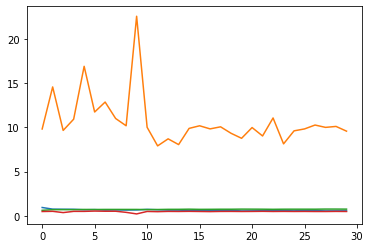

In [14]:
plt.plot(hist)

In [15]:
model = torch.load('exploss_benchamrk_rafdb/resExploss_originalRAFDB_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 11.7350 | Avg. val_acc: 0.5492


In [16]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3068, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[-23.853472, -34.87307 ],
        [-26.908606, -41.0869  ],
        [-20.704508,  32.120956],
        ...,
        [ 53.6662  ,  30.374369],
        [ 54.889763,  29.513023],
        [ 39.989258,  22.637493]], dtype=float32))

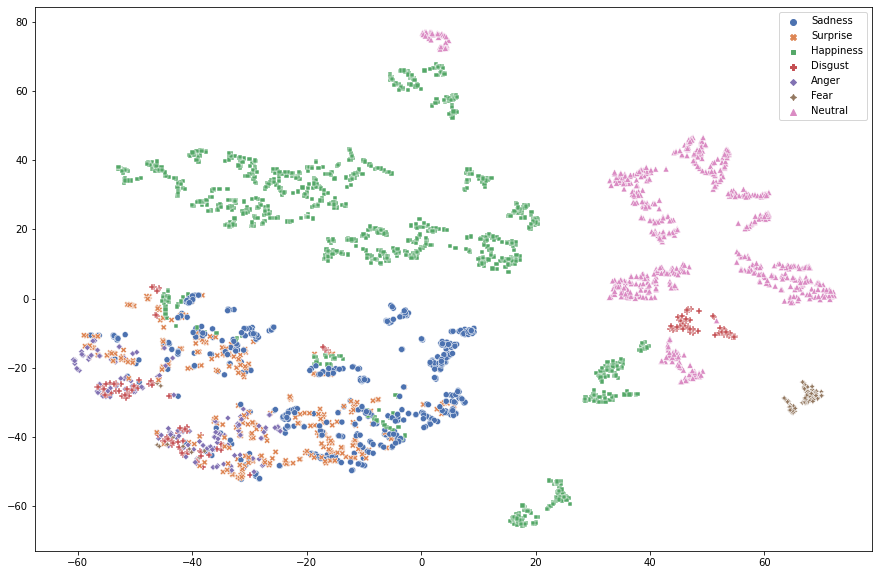

In [17]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)


### Resnet50

In [ ]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
        torch.nn.i
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
    
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [30]:
class Resnet50_exp(nn.Module):
    def __init__(self, sample_model, in_features_classifier=2048, n_classes=100):
        super(Resnet50_exp, self).__init__()
        
#         self.conv1 = sample_model.conv1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = sample_model.bn1
        self.relu = sample_model.relu
        self.maxpool = sample_model.maxpool
        
        self.layer1 = sample_model.layer1
        self.layer2 = sample_model.layer2
        self.layer3 = sample_model.layer3
        self.layer4 = sample_model.layer4
        
        self.avgpool = sample_model.avgpool
        
        self.exploss = ExpLoss(in_features_classifier)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, n_classes))
                                        
    def forward(self, x, labels, return_att=True):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        att, sim_loss = self.exploss(x, labels)

        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

In [31]:
# create model
device = torch.device('cuda')
lr = 1e-4
model = Resnet50_exp(sample_model=models.resnet50(pretrained=False), in_features_classifier=2048, n_classes=7)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

In [20]:
model_path = 'exploss_benchamrk_rafdb/resExploss_originalRAFDB_resnet50_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch:  1


Loss=0.5877528786659241 Batch_id=191 Accuracy=0.7659574468085106: 100%|██████████| 192/192 [00:25<00:00,  7.61it/s]

- Avg.loss: 0.9586 | Avg.acc: 0.6427


- Avg. test_loss: 7.9239 | Avg. test_acc: 0.5443


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=0.37160637974739075 Batch_id=191 Accuracy=0.8723404255319149: 100%|██████████| 192/192 [00:25<00:00,  7.56it/s]

- Avg.loss: 0.6874 | Avg.acc: 0.7386



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 6.7303 | Avg. test_acc: 0.3761
Epoch:  3


Loss=0.9303604960441589 Batch_id=191 Accuracy=0.574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.55it/s]

- Avg.loss: 0.6357 | Avg.acc: 0.7646



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 5.7213 | Avg. test_acc: 0.5196
Epoch:  4


Loss=1.03224515914917 Batch_id=191 Accuracy=0.5106382978723404: 100%|██████████| 192/192 [00:25<00:00,  7.53it/s]

- Avg.loss: 0.6429 | Avg.acc: 0.7567


- Avg. test_loss: 10.3030 | Avg. test_acc: 0.5518


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.0028600692749023 Batch_id=191 Accuracy=0.3404255319148936: 100%|██████████| 192/192 [00:25<00:00,  7.50it/s]

- Avg.loss: 0.5651 | Avg.acc: 0.7835



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 6.2124 | Avg. test_acc: 0.5059
Epoch:  6


Loss=1.0138322114944458 Batch_id=191 Accuracy=0.6595744680851063: 100%|██████████| 192/192 [00:25<00:00,  7.58it/s]

- Avg.loss: 0.5781 | Avg.acc: 0.7792



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 7.8561 | Avg. test_acc: 0.5055
Epoch:  7


Loss=0.26517194509506226 Batch_id=191 Accuracy=0.851063829787234: 100%|██████████| 192/192 [00:25<00:00,  7.53it/s]

- Avg.loss: 0.5073 | Avg.acc: 0.8076



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.2566 | Avg. test_acc: 0.5453
Epoch:  8


Loss=0.458126425743103 Batch_id=191 Accuracy=0.7872340425531915: 100%|██████████| 192/192 [00:25<00:00,  7.48it/s]

- Avg.loss: 0.4526 | Avg.acc: 0.8338


- Avg. test_loss: 5.1548 | Avg. test_acc: 0.6056


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.4299323260784149 Batch_id=191 Accuracy=0.8297872340425532: 100%|██████████| 192/192 [00:25<00:00,  7.55it/s]

- Avg.loss: 0.3804 | Avg.acc: 0.8563



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 5.5578 | Avg. test_acc: 0.5890
Epoch:  10


Loss=0.15990544855594635 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.54it/s]

- Avg.loss: 0.3677 | Avg.acc: 0.8604



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.5400 | Avg. test_acc: 0.5737
Epoch:  11


Loss=0.18661734461784363 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:25<00:00,  7.55it/s]

- Avg.loss: 0.2564 | Avg.acc: 0.9095



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.8690 | Avg. test_acc: 0.5851
Epoch:  12


Loss=0.4275416433811188 Batch_id=191 Accuracy=0.851063829787234: 100%|██████████| 192/192 [00:25<00:00,  7.57it/s]

- Avg.loss: 0.2698 | Avg.acc: 0.9026



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 4.7735 | Avg. test_acc: 0.6056
Epoch:  13


Loss=0.32997897267341614 Batch_id=191 Accuracy=0.8085106382978723: 100%|██████████| 192/192 [00:25<00:00,  7.53it/s]

- Avg.loss: 0.2426 | Avg.acc: 0.9148



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.8621 | Avg. test_acc: 0.5743
Epoch:  14


Loss=0.381255179643631 Batch_id=191 Accuracy=0.8297872340425532: 100%|██████████| 192/192 [00:25<00:00,  7.53it/s]

- Avg.loss: 0.2798 | Avg.acc: 0.9064


- Avg. test_loss: 3.1387 | Avg. test_acc: 0.6196


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=0.7838516235351562 Batch_id=191 Accuracy=0.7872340425531915: 100%|██████████| 192/192 [00:25<00:00,  7.48it/s]

- Avg.loss: 0.2348 | Avg.acc: 0.9210


- Avg. test_loss: 2.6969 | Avg. test_acc: 0.7177


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.14483405649662018 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.45it/s]

- Avg.loss: 0.1992 | Avg.acc: 0.9318



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.3101 | Avg. test_acc: 0.6359
Epoch:  17


Loss=0.11079887300729752 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.52it/s]      

- Avg.loss: 0.1136 | Avg.acc: 0.9628



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.7053 | Avg. test_acc: 0.7044
Epoch:  18


Loss=0.08236213028430939 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.51it/s]

- Avg.loss: 0.0786 | Avg.acc: 0.9760



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 5.1148 | Avg. test_acc: 0.5772
Epoch:  19


Loss=0.1075461283326149 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.59it/s]

- Avg.loss: 0.0552 | Avg.acc: 0.9838


- Avg. test_loss: 2.3599 | Avg. test_acc: 0.7419


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.3620283603668213 Batch_id=191 Accuracy=0.8936170212765957: 100%|██████████| 192/192 [00:25<00:00,  7.53it/s]

- Avg.loss: 0.0533 | Avg.acc: 0.9833



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.8690 | Avg. test_acc: 0.6336
Epoch:  21


Loss=0.1317513883113861 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:25<00:00,  7.50it/s]

- Avg.loss: 0.0604 | Avg.acc: 0.9808



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.8942 | Avg. test_acc: 0.6105
Epoch:  22


Loss=0.0029488808941096067 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.54it/s]    

- Avg.loss: 0.0310 | Avg.acc: 0.9919


- Avg. test_loss: 2.1907 | Avg. test_acc: 0.8103


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.003060188377276063 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]     

- Avg.loss: 0.0156 | Avg.acc: 0.9962



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 5.6358 | Avg. test_acc: 0.6141
Epoch:  24


Loss=0.028658879920840263 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.50it/s]     

- Avg.loss: 0.0270 | Avg.acc: 0.9913



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 4.1315 | Avg. test_acc: 0.6757
Epoch:  25


Loss=0.05138755217194557 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.50it/s]

- Avg.loss: 0.0368 | Avg.acc: 0.9893



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.0620 | Avg. test_acc: 0.7132
Epoch:  26


Loss=1.0072404146194458 Batch_id=191 Accuracy=0.6808510638297872: 100%|██████████| 192/192 [00:25<00:00,  7.41it/s]

- Avg.loss: 0.0433 | Avg.acc: 0.9858



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.0139 | Avg. test_acc: 0.6754
Epoch:  27


Loss=0.028161538764834404 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]     

- Avg.loss: 0.1319 | Avg.acc: 0.9545



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.5703 | Avg. test_acc: 0.5854
Epoch:  28


Loss=0.24721011519432068 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.45it/s]

- Avg.loss: 0.1985 | Avg.acc: 0.9323



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.1697 | Avg. test_acc: 0.6574
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  29


Loss=0.3521459400653839 Batch_id=191 Accuracy=0.8936170212765957: 100%|██████████| 192/192 [00:25<00:00,  7.55it/s]

- Avg.loss: 0.1054 | Avg.acc: 0.9675



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.4613 | Avg. test_acc: 0.7018
Epoch:  30


Loss=3.7615292072296143 Batch_id=191 Accuracy=0.2127659574468085: 100%|██████████| 192/192 [00:25<00:00,  7.45it/s]

- Avg.loss: 0.0759 | Avg.acc: 0.9800



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.3198 | Avg. test_acc: 0.7233
Epoch:  31


Loss=0.2968491017818451 Batch_id=191 Accuracy=0.8936170212765957: 100%|██████████| 192/192 [00:25<00:00,  7.54it/s]

- Avg.loss: 0.0477 | Avg.acc: 0.9864



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.1181 | Avg. test_acc: 0.7705
Epoch:  32


Loss=0.00943284947425127 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.47it/s]      

- Avg.loss: 0.0380 | Avg.acc: 0.9904



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.9951 | Avg. test_acc: 0.7581
Epoch:  33


Loss=0.011705825105309486 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.48it/s]     

- Avg.loss: 0.0338 | Avg.acc: 0.9904


- Avg. test_loss: 2.2060 | Avg. test_acc: 0.8178


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=0.004898001905530691 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.54it/s]     

- Avg.loss: 0.0297 | Avg.acc: 0.9923



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.0496 | Avg. test_acc: 0.7767
Epoch:  35


Loss=0.030963946133852005 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.49it/s]     

- Avg.loss: 0.0341 | Avg.acc: 0.9900



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.1788 | Avg. test_acc: 0.7585
Epoch:  36


Loss=0.026163863018155098 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.52it/s]     

- Avg.loss: 0.0197 | Avg.acc: 0.9943



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.2974 | Avg. test_acc: 0.7598
Epoch:  37


Loss=0.35210564732551575 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.48it/s]

- Avg.loss: 0.0180 | Avg.acc: 0.9954



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.3671 | Avg. test_acc: 0.7842
Epoch:  38


Loss=0.06633162498474121 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.50it/s]

- Avg.loss: 0.0178 | Avg.acc: 0.9955



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.1553 | Avg. test_acc: 0.7653
Epoch:  39


Loss=0.005718338768929243 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]    

- Avg.loss: 0.0109 | Avg.acc: 0.9980



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.7832 | Avg. test_acc: 0.7712
Epoch    39: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  40


Loss=0.005125734955072403 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.49it/s]     

- Avg.loss: 0.0104 | Avg.acc: 0.9980



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.9824 | Avg. test_acc: 0.7686
Epoch:  41


Loss=0.008668612688779831 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.51it/s]     

- Avg.loss: 0.0099 | Avg.acc: 0.9975



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 3.1956 | Avg. test_acc: 0.7595
Epoch:  42


Loss=0.02223069593310356 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.53it/s]      

- Avg.loss: 0.0103 | Avg.acc: 0.9976



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.7713 | Avg. test_acc: 0.7549
Epoch:  47


Loss=0.01608985848724842 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.47it/s]      

- Avg.loss: 0.0089 | Avg.acc: 0.9977



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.3416 | Avg. test_acc: 0.7757
Epoch:  48


Loss=0.0029840522911399603 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.46it/s]   

- Avg.loss: 0.0103 | Avg.acc: 0.9974



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.4958 | Avg. test_acc: 0.7647
Epoch:  49


Loss=0.034910932183265686 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.56it/s]    

- Avg.loss: 0.0084 | Avg.acc: 0.9985



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.7344 | Avg. test_acc: 0.7699
Epoch:  50


Loss=0.0007024467340670526 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]    

- Avg.loss: 0.0121 | Avg.acc: 0.9967


- Avg. test_loss: 2.3010 | Avg. test_acc: 0.7666


In [21]:
pickle.dump(hist, open('exploss_benchamrk_rafdb/resExploss_originalRAFDB_resnet50_hist.hdf5', 'wb'))

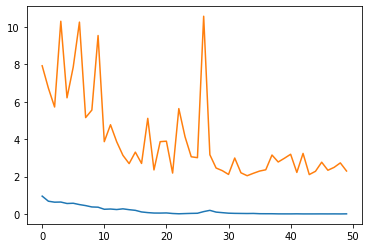

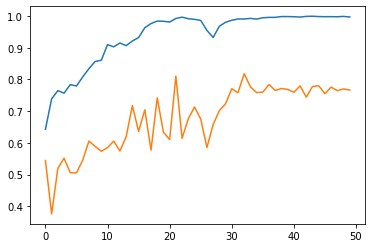

(0.8177966101694916, 2.205959381722642)

In [24]:
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()

plt.plot([k[2] for k in hist])
plt.plot([k[3] for k in hist])
plt.show()
best_acc, curloss

In [25]:
model = torch.load('exploss_benchamrk_rafdb/resExploss_originalRAFDB_resnet50_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 2.2060 | Avg. val_acc: 0.8178


In [26]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3068, 2048])

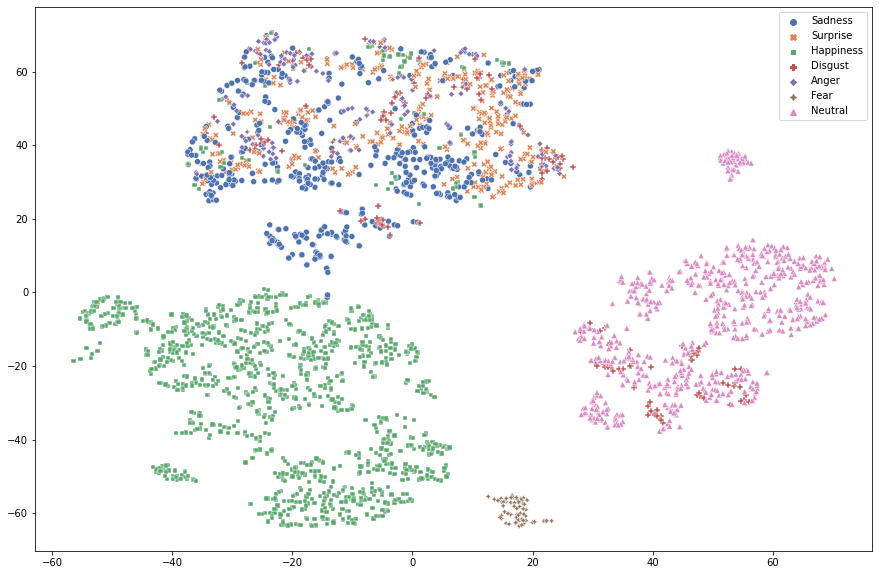

In [28]:
_, _ = visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_benchamrk_rafdb/resExploss_originalRAFDB_resnet50_tsne.png')

## Minimize the similarity

In [19]:
EPS = 1e-15
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
            
            
        # att and non-att as additional loss
        # maximize the similarity (dot-product) of samples having SAMLE labels
        # minimize the one of samples having DIFFERENT labels
        same_att = sims.sigmoid() * (1 - mask.to(sims.device))
        same_att = same_att[same_att != 0]
        
        opst_att = sims.sigmoid() * mask.to(sims.device) # the opposite att contaning samples with different labels
        opst_att = opst_att[opst_att != 0] if len(opst_att[opst_att != 0]) > 0 else torch.tensor([0.])
        
#         print('non zero in mask (different labels): ', (mask != 0).sum())
        
#         if ((1 - same_att) <= 0).any():
#             print('1 - same_att is negative: ', 1 - same_att)
            
#         if (opst_att <= 0).any():
#             print('opst_att is negative: ', opst_att)
#             print('mask: ', mask)
            
        
        same_sims = -torch.log(1 - same_att + EPS).mean()
        opst_sims = -torch.log(opst_att + EPS).mean()
        
#         if torch.isnan(same_sims).any():
#             print('1 - same_att: ', 1 - same_att)
#         if torch.isnan(opst_sims).any():
#             print('opst_att: ', opst_att)
        
       
        
        sim_loss = (0.5 * same_sims) + (0.5 * opst_sims)
#         sim_loss = (0.5 * (1 - same_sims)) + (0.5 * opst_sims)
        
        return x, sim_loss

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [6]:
# class sVGG_exp(nn.Module):
#     def __init__(self, features, in_features_classifier, n_classes, residual=True):
#         super(sVGG_exp, self).__init__()
#         self.features = features
#         self.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
#         self.exploss = ExpLoss(512, residual=residual)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
#         self.classifier = nn.Sequential(nn.Flatten(),
#                                         nn.Linear(in_features_classifier, in_features_classifier),
#                                         nn.ReLU(inplace=True),
#                                         nn.Dropout(0.5, inplace=False),
#                                         nn.Linear(in_features_classifier, in_features_classifier // 2),
#                                         nn.ReLU(inplace=True),
#                                         nn.Dropout(0.5, inplace=False),
#                                         nn.Linear(in_features_classifier // 2, n_classes))
        
#     def forward(self, x, labels, return_att=True):
#         x = self.features(x)
#         att, sim_loss = self.exploss(x, labels)

# #         att = self.avgpool(x)
#         x = self.classifier(att)
        
#         if return_att:
#             return x, sim_loss, att
#         return x, sim_loss


In [20]:
from torchvision.models import vgg16_bn
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

NameError: name 'sVGG_exp' is not defined

In [8]:
lr = 0.0005
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [9]:
model_path = 'exploss_benchamrk_rafdb/resExploss_simloss_originalRAFDB_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch:  1


Loss=1.996014952659607 Batch_id=28 Accuracy=0.53125:  15%|█▌        | 29/192 [00:04<00:28,  5.80it/s]  


KeyboardInterrupt: 

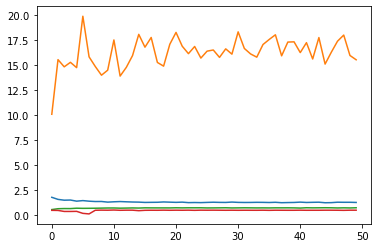

In [30]:
plt.plot(hist)

In [10]:
model = torch.load('exploss_benchamrk_rafdb/resExploss_simloss_originalRAFDB_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 12.9825 | Avg. val_acc: 0.5388


In [11]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3068, 512])

In [15]:
fig, (tsne, strlabels) = visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)


In [18]:
tsne.shape, len(strlabels)

((3068, 2), 3068)

In [32]:
model_path = 'exploss_benchamrk_rafdb/resExploss_simloss_originalRAFDB_resnet50_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels)  + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch:  1


Loss=2.009748697280884 Batch_id=191 Accuracy=0.5319148936170213: 100%|██████████| 192/192 [00:25<00:00,  7.63it/s]

- Avg.loss: 2.0279 | Avg.acc: 0.5768



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.4148 | Avg. test_acc: 0.4478
* Update optimal model
Epoch:  2


Loss=2.4175877571105957 Batch_id=191 Accuracy=0.6595744680851063: 100%|██████████| 192/192 [00:25<00:00,  7.58it/s]

- Avg.loss: 1.7016 | Avg.acc: 0.6704


- Avg. test_loss: 8.1966 | Avg. test_acc: 0.4909


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.5354052782058716 Batch_id=191 Accuracy=0.7021276595744681: 100%|██████████| 192/192 [00:25<00:00,  7.50it/s]

- Avg.loss: 1.5213 | Avg.acc: 0.7249


- Avg. test_loss: 11.7266 | Avg. test_acc: 0.5134


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.8376713991165161 Batch_id=191 Accuracy=0.48936170212765956: 100%|██████████| 192/192 [00:25<00:00,  7.54it/s]

- Avg.loss: 1.9061 | Avg.acc: 0.7147



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.4155 | Avg. test_acc: 0.4958
Epoch:  5


Loss=1.3873990774154663 Batch_id=191 Accuracy=0.7446808510638298: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 1.4577 | Avg.acc: 0.7310



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.2943 | Avg. test_acc: 0.5108
Epoch:  6


Loss=1.3180121183395386 Batch_id=191 Accuracy=0.8085106382978723: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]

- Avg.loss: 1.2803 | Avg.acc: 0.7907



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.5781 | Avg. test_acc: 0.5010
Epoch:  7


Loss=1.038562536239624 Batch_id=191 Accuracy=0.8723404255319149: 100%|██████████| 192/192 [00:25<00:00,  7.49it/s]

- Avg.loss: 1.2585 | Avg.acc: 0.7952


- Avg. test_loss: 13.2661 | Avg. test_acc: 0.5522


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.1558071374893188 Batch_id=191 Accuracy=0.7659574468085106: 100%|██████████| 192/192 [00:25<00:00,  7.47it/s]

- Avg.loss: 1.2367 | Avg.acc: 0.8009



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.4945 | Avg. test_acc: 0.5121
Epoch:  9


Loss=0.8665644526481628 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 1.1847 | Avg.acc: 0.8227



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.4452 | Avg. test_acc: 0.5362
Epoch:  10


Loss=1.7861254215240479 Batch_id=191 Accuracy=0.6382978723404256: 100%|██████████| 192/192 [00:25<00:00,  7.49it/s]

- Avg.loss: 1.0861 | Avg.acc: 0.8477



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.4390 | Avg. test_acc: 0.4743
Epoch:  11


Loss=1.7763242721557617 Batch_id=191 Accuracy=0.40425531914893614: 100%|██████████| 192/192 [00:25<00:00,  7.50it/s]

- Avg.loss: 1.1185 | Avg.acc: 0.8441



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.0827 | Avg. test_acc: 0.5248
Epoch:  12


Loss=1.2004287242889404 Batch_id=191 Accuracy=0.7872340425531915: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 1.1529 | Avg.acc: 0.8296



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 8.1024 | Avg. test_acc: 0.5029
Epoch:  13


Loss=1.339604377746582 Batch_id=191 Accuracy=0.7446808510638298: 100%|██████████| 192/192 [00:26<00:00,  7.36it/s]

- Avg.loss: 1.0550 | Avg.acc: 0.8655



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 9.9892 | Avg. test_acc: 0.4687
Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  14


Loss=1.0158438682556152 Batch_id=191 Accuracy=0.8085106382978723: 100%|██████████| 192/192 [00:25<00:00,  7.42it/s]

- Avg.loss: 1.0905 | Avg.acc: 0.8592


- Avg. test_loss: 10.6636 | Avg. test_acc: 0.5704


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=0.8829382658004761 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:26<00:00,  7.37it/s]

- Avg.loss: 1.0323 | Avg.acc: 0.8731



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.9810 | Avg. test_acc: 0.5443
Epoch:  16


Loss=1.081295371055603 Batch_id=191 Accuracy=0.8723404255319149: 100%|██████████| 192/192 [00:26<00:00,  7.37it/s]

- Avg.loss: 0.9890 | Avg.acc: 0.8915



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.2831 | Avg. test_acc: 0.5684
Epoch:  17


Loss=0.8530993461608887 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.41it/s]

- Avg.loss: 0.9693 | Avg.acc: 0.8987



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 12.7852 | Avg. test_acc: 0.5623
Epoch:  18


Loss=0.9738715887069702 Batch_id=191 Accuracy=0.8723404255319149: 100%|██████████| 192/192 [00:25<00:00,  7.42it/s]

- Avg.loss: 0.9244 | Avg.acc: 0.9146


- Avg. test_loss: 13.1768 | Avg. test_acc: 0.5737


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=0.8208755254745483 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]

- Avg.loss: 0.9186 | Avg.acc: 0.9152



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 12.2218 | Avg. test_acc: 0.5427
Epoch:  20


Loss=0.9136083126068115 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.46it/s]

- Avg.loss: 0.8903 | Avg.acc: 0.9280



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.0732 | Avg. test_acc: 0.5567
Epoch:  21


Loss=0.8963062763214111 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.45it/s]

- Avg.loss: 0.8603 | Avg.acc: 0.9408



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 15.4682 | Avg. test_acc: 0.5163
Epoch:  22


Loss=0.9467710256576538 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:25<00:00,  7.39it/s]

- Avg.loss: 0.8547 | Avg.acc: 0.9408



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.7815 | Avg. test_acc: 0.5531
Epoch:  23


Loss=0.8402329087257385 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 0.8390 | Avg.acc: 0.9488



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 12.6084 | Avg. test_acc: 0.5303
Epoch:  24


Loss=0.9867453575134277 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.41it/s]

- Avg.loss: 0.8221 | Avg.acc: 0.9557



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.6014 | Avg. test_acc: 0.5362
Epoch    24: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  25


Loss=0.8323430418968201 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.45it/s]

- Avg.loss: 0.8175 | Avg.acc: 0.9597



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 12.6539 | Avg. test_acc: 0.5473
Epoch:  26


Loss=0.7965782880783081 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:26<00:00,  7.33it/s]

- Avg.loss: 0.8170 | Avg.acc: 0.9593



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.6164 | Avg. test_acc: 0.5404
Epoch:  27


Loss=0.8190532922744751 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.41it/s]

- Avg.loss: 0.8063 | Avg.acc: 0.9639



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.5294 | Avg. test_acc: 0.5535
Epoch:  28


Loss=0.9011183977127075 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.45it/s]

- Avg.loss: 0.8083 | Avg.acc: 0.9624



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 14.4497 | Avg. test_acc: 0.5675
Epoch:  29


Loss=0.7314854860305786 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:26<00:00,  7.32it/s]     

- Avg.loss: 0.8108 | Avg.acc: 0.9601



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.0144 | Avg. test_acc: 0.5522
Epoch:  30


Loss=0.7526395320892334 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:26<00:00,  7.35it/s]     

- Avg.loss: 0.7992 | Avg.acc: 0.9662



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.2660 | Avg. test_acc: 0.5469
Epoch    30: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  31


Loss=0.9389919638633728 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:26<00:00,  7.37it/s]

- Avg.loss: 0.8000 | Avg.acc: 0.9641



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 12.0550 | Avg. test_acc: 0.5632
Epoch:  32


Loss=0.7815420031547546 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 0.8014 | Avg.acc: 0.9684



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.6403 | Avg. test_acc: 0.5570
Epoch:  33


Loss=0.8546169996261597 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:26<00:00,  7.35it/s]

- Avg.loss: 0.8052 | Avg.acc: 0.9650



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.6885 | Avg. test_acc: 0.5600
Epoch:  34


Loss=1.2957069873809814 Batch_id=191 Accuracy=0.7446808510638298: 100%|██████████| 192/192 [00:26<00:00,  7.38it/s]

- Avg.loss: 0.8000 | Avg.acc: 0.9655



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.8985 | Avg. test_acc: 0.5460
Epoch:  35


Loss=0.7879937887191772 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s]

- Avg.loss: 0.8000 | Avg.acc: 0.9677



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.7642 | Avg. test_acc: 0.5577
Epoch:  36


Loss=1.096430778503418 Batch_id=191 Accuracy=0.7021276595744681: 100%|██████████| 192/192 [00:26<00:00,  7.36it/s]

- Avg.loss: 0.8049 | Avg.acc: 0.9670



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.0527 | Avg. test_acc: 0.5456
Epoch    36: reducing learning rate of group 0 to 1.0000e-08.
Epoch:  37


Loss=0.8099805116653442 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.43it/s]

- Avg.loss: 0.8030 | Avg.acc: 0.9659



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.5396 | Avg. test_acc: 0.5538
Epoch:  38


Loss=0.7931139469146729 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:26<00:00,  7.36it/s]

- Avg.loss: 0.8009 | Avg.acc: 0.9658



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.7698 | Avg. test_acc: 0.5407
Epoch:  39


Loss=0.7641561031341553 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.47it/s]     

- Avg.loss: 0.7995 | Avg.acc: 0.9669



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 12.4627 | Avg. test_acc: 0.5574
Epoch:  40


Loss=0.8513804078102112 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:26<00:00,  7.38it/s]

- Avg.loss: 0.8036 | Avg.acc: 0.9635



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.2929 | Avg. test_acc: 0.5535
Epoch:  41


Loss=0.9164922833442688 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.40it/s]

- Avg.loss: 0.7975 | Avg.acc: 0.9674


- Avg. test_loss: 12.6883 | Avg. test_acc: 0.5789


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=0.8487235903739929 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:26<00:00,  7.35it/s]

- Avg.loss: 0.8017 | Avg.acc: 0.9652



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.4306 | Avg. test_acc: 0.5453
Epoch:  43


Loss=0.7680817246437073 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.47it/s]

- Avg.loss: 0.8044 | Avg.acc: 0.9650



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 10.9677 | Avg. test_acc: 0.5495
Epoch:  44


Loss=0.7744335532188416 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.39it/s]

- Avg.loss: 0.8032 | Avg.acc: 0.9628



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.0533 | Avg. test_acc: 0.5489
Epoch:  45


Loss=0.9787824153900146 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.40it/s]

- Avg.loss: 0.8067 | Avg.acc: 0.9628



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.6897 | Avg. test_acc: 0.5577
Epoch:  46


Loss=0.8653963208198547 Batch_id=191 Accuracy=0.9361702127659575: 100%|██████████| 192/192 [00:25<00:00,  7.40it/s]

- Avg.loss: 0.7998 | Avg.acc: 0.9673



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 13.1303 | Avg. test_acc: 0.5450
Epoch:  47


Loss=0.9221817255020142 Batch_id=191 Accuracy=0.9787234042553191: 100%|██████████| 192/192 [00:25<00:00,  7.40it/s]

- Avg.loss: 0.8022 | Avg.acc: 0.9643



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.1663 | Avg. test_acc: 0.5372
Epoch:  48


Loss=0.8296006321907043 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:26<00:00,  7.36it/s]     

- Avg.loss: 0.7962 | Avg.acc: 0.9673



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.0509 | Avg. test_acc: 0.5525
Epoch:  49


Loss=0.9915837049484253 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.42it/s]

- Avg.loss: 0.8060 | Avg.acc: 0.9653



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 11.6021 | Avg. test_acc: 0.5271
Epoch:  50


Loss=0.8377372026443481 Batch_id=191 Accuracy=0.9148936170212766: 100%|██████████| 192/192 [00:25<00:00,  7.40it/s]

- Avg.loss: 0.8093 | Avg.acc: 0.9659


- Avg. test_loss: 12.3563 | Avg. test_acc: 0.5671


In [33]:
model = torch.load('exploss_benchamrk_rafdb/resExploss_simloss_originalRAFDB_resnet50_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 8.1385 | Avg. val_acc: 0.5789


In [34]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3068, 2048])

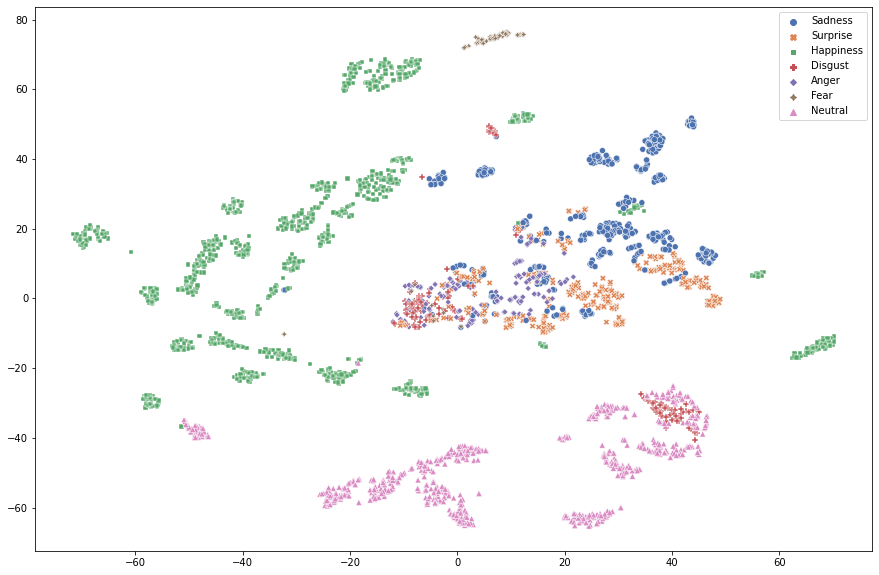

In [36]:
fig, (tsne, strlabels) = visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_benchamrk_rafdb/resExploss_simloss_originalRAFDB_resnet50_tsne.png')


## Discover groups of a single label

In [36]:
# check happiness
consider_label = 'Happiness'
indices = np.where(np.array(strlabels) == consider_label)[0]

consider_tsne = tsne[indices]

In [83]:
inputs = []
inv_labeldict = {v:k for k, v in label_dict.items()}
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    _inputs, labels = data
    _inputs = _inputs[labels == inv_labeldict[consider_label]]
    with torch.no_grad():
        inputs.append(_inputs)
inputs = torch.cat(inputs, dim=0)

In [80]:
# cluster into smaller groups
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=30).fit(consider_tsne)
groups = np.unique(clustering.labels_)
print(groups)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


Distribution of groups in the same label: Happiness


<AxesSubplot:>

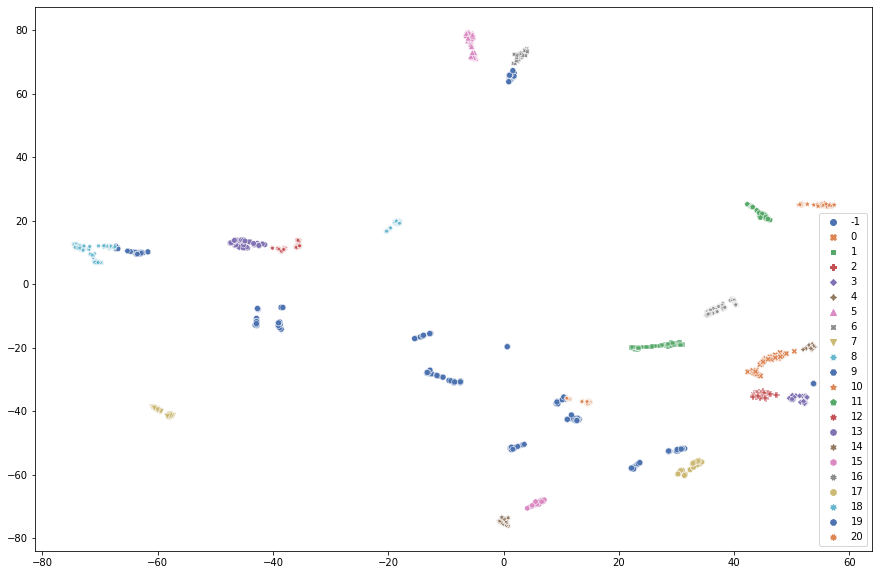

In [99]:
print('Distribution of groups in the same label:', consider_label)
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=consider_tsne[:,0], y=consider_tsne[:,1], 
                hue=clustering.labels_, style=clustering.labels_, palette="deep")

Group  -1


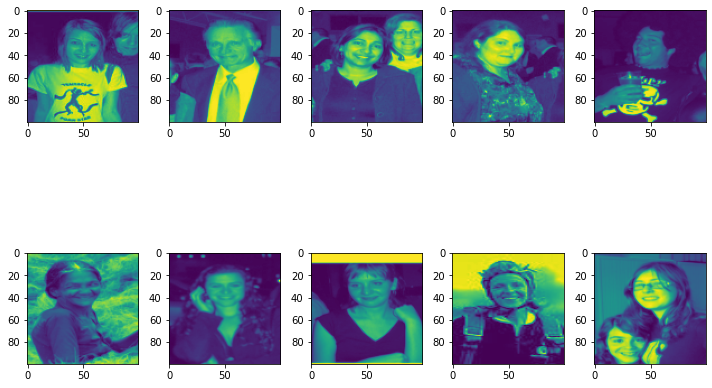

Group  0


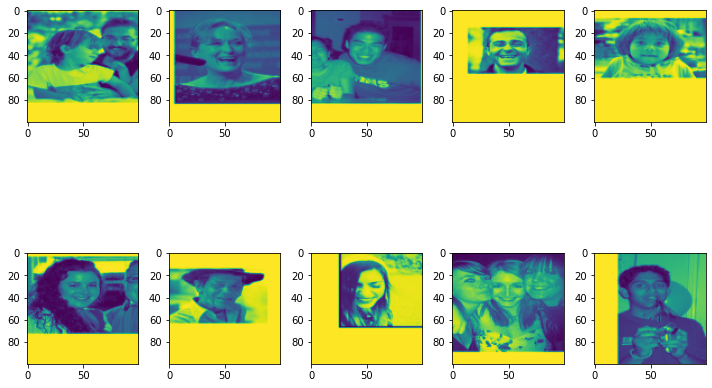

Group  1


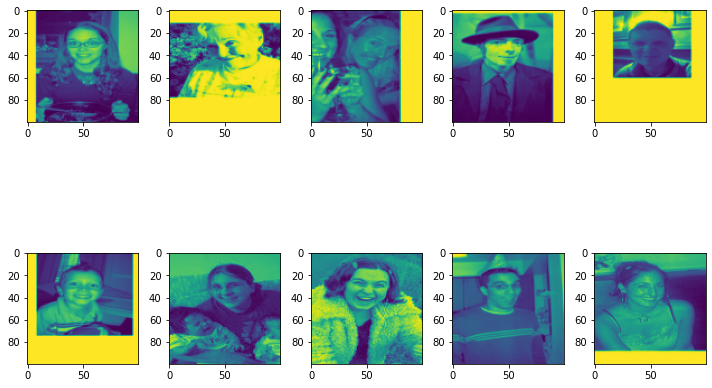

Group  2


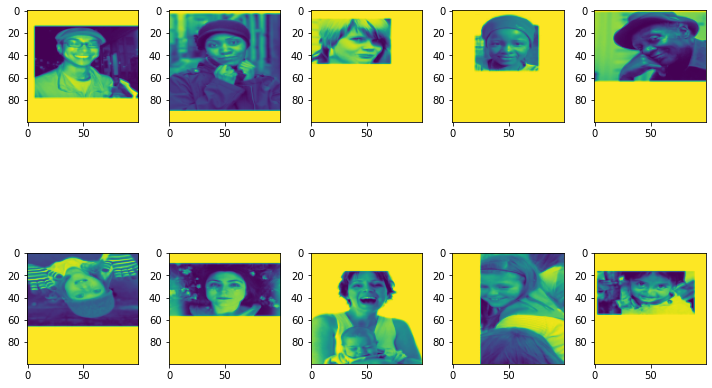

Group  3


Group  4


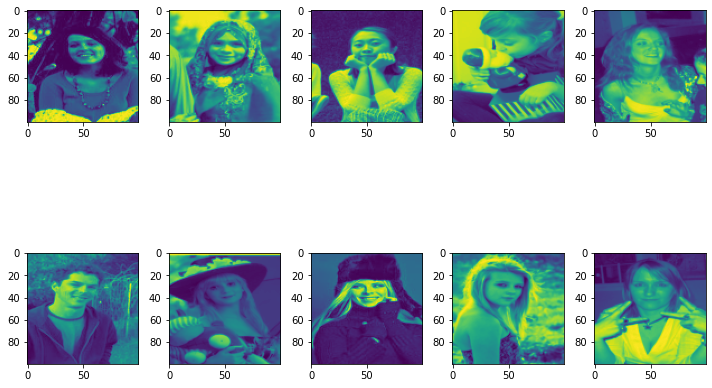

Group  5


Group  6


Group  7


Group  8


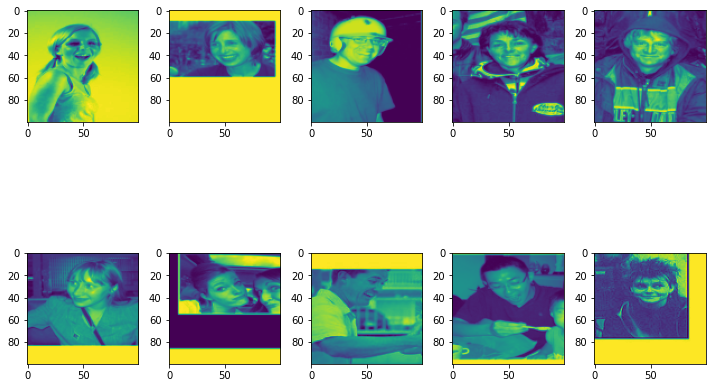

Group  9


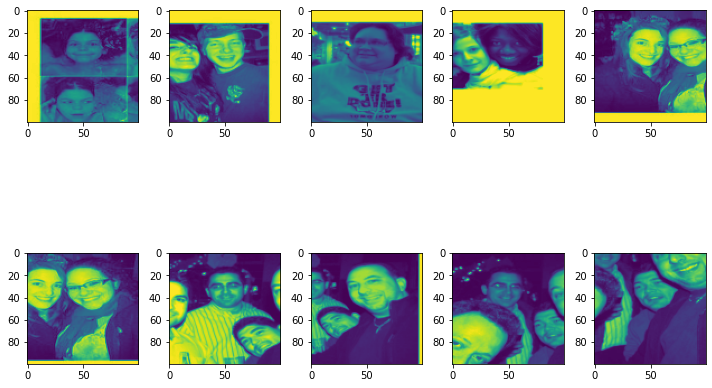

Group  10


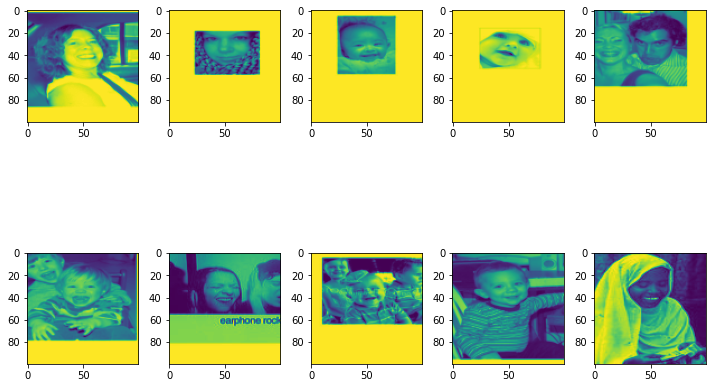

Group  11


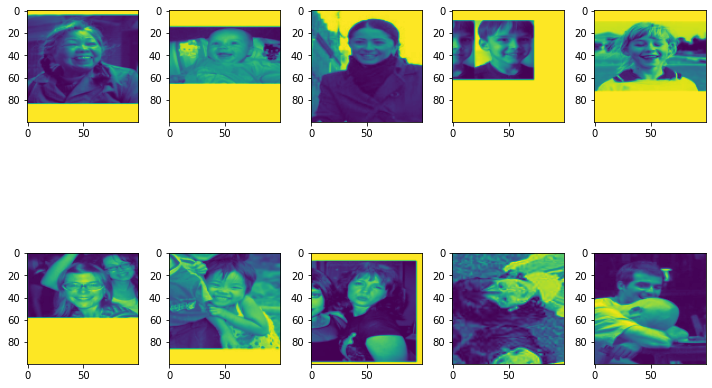

Group  12


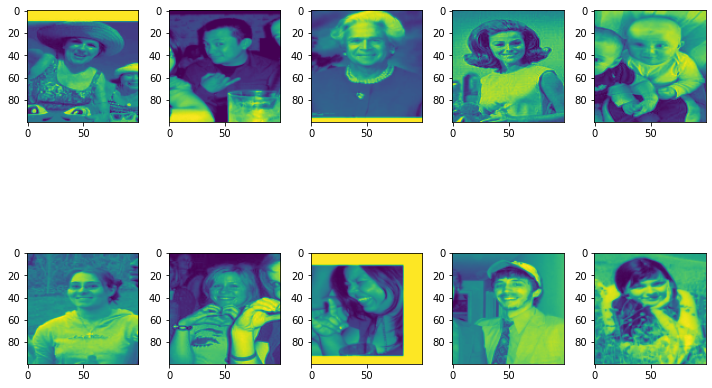

Group  13


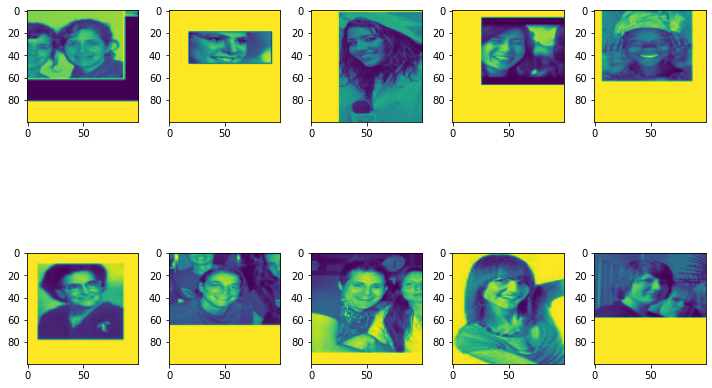

Group  14


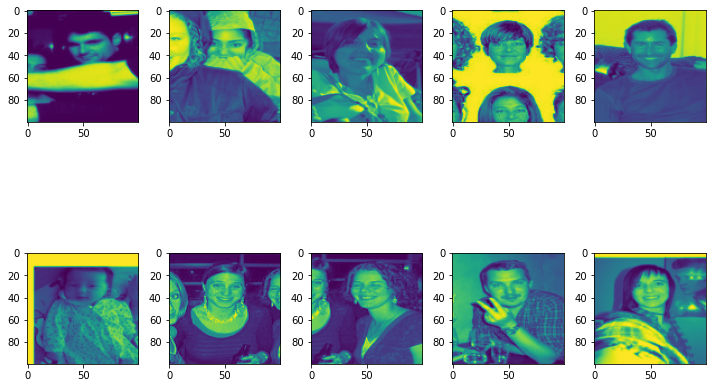

Group  15


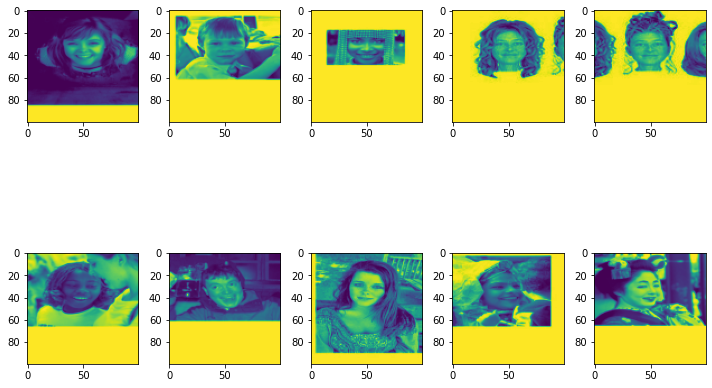

Group  16


Group  17


Group  18


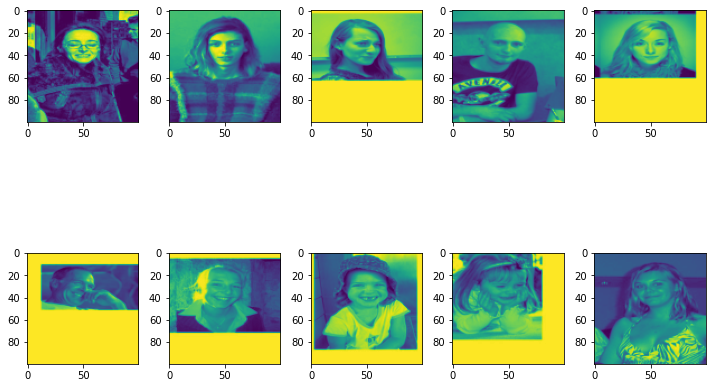

Group  19


Group  20


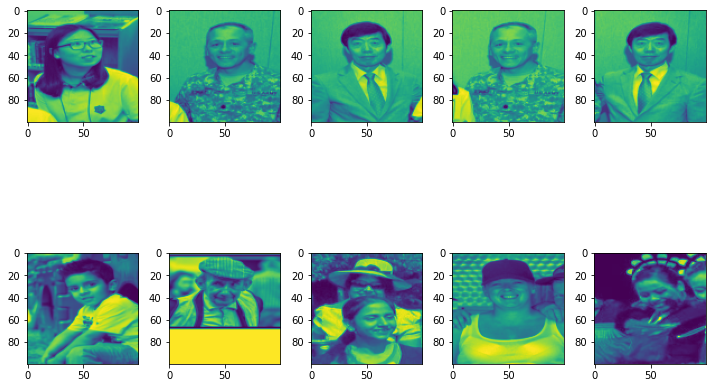

In [101]:
%matplotlib inline

rows = 2
cols = topk // rows

# groups = [12, 8]

for group in groups:
    indices = (clustering.labels_ == group)
    show_inputs = inputs[indices][:topk]
    index = 0
    
    fig, axs = plt.subplots(rows, cols, figsize=(10,8))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(show_inputs[index][0])
            index += 1
    print('Group ', group)
    plt.tight_layout()
    plt.show()

## Add dedicated features

### Alter to original ExpLoss

In [14]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True, nclasses=7):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
        # bridge features
        self.bridge_features = nn.Parameter(torch.rand(nclasses, depth))
        self.bridge_labels = torch.arange(nclasses)
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        # add bridge features
        x = torch.cat([x, self.bridge_features.to(x.device)], dim=0)
        
        if labels is not None:
            labels = torch.cat([labels, self.bridge_labels.to(labels.device)], dim=0)
        
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        
        if labels is not None:
            mask = self.filter_mask(labels)
            att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
        else:
            mask = torch.where(sims < 0.5, 1, 0)
            att = sims * (1 - mask.to(sims.device))
        
        # TEMP SOLUTION: remove bridge features of row to ensure the original batch size
        att = att[:batch_size, :]
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [4]:
import torch

a = torch.rand(12,12)
print(a)
torch.where(a > 0.5, 1, 0)

tensor([[0.5775, 0.4117, 0.1984, 0.9768, 0.5530, 0.8779, 0.1874, 0.7201, 0.8505,
         0.6494, 0.8058, 0.6204],
        [0.1472, 0.7215, 0.0976, 0.0865, 0.5499, 0.8436, 0.7648, 0.8503, 0.2462,
         0.2478, 0.2236, 0.4440],
        [0.3472, 0.2986, 0.6841, 0.2270, 0.6514, 0.8017, 0.3154, 0.4345, 0.3045,
         0.1601, 0.9157, 0.2272],
        [0.2845, 0.0175, 0.0975, 0.9510, 0.3781, 0.9878, 0.4013, 0.1967, 0.2377,
         0.5876, 0.5531, 0.1354],
        [0.4249, 0.9030, 0.1861, 0.1168, 0.0688, 0.5007, 0.7870, 0.7536, 0.2767,
         0.3586, 0.3792, 0.4620],
        [0.1691, 0.5766, 0.0056, 0.1672, 0.5525, 0.2058, 0.4926, 0.3905, 0.4663,
         0.6592, 0.2474, 0.8999],
        [0.2706, 0.6116, 0.9830, 0.6860, 0.0243, 0.8423, 0.9854, 0.2135, 0.9428,
         0.6589, 0.4201, 0.7733],
        [0.3548, 0.4886, 0.1407, 0.6518, 0.7321, 0.2090, 0.2594, 0.9169, 0.8111,
         0.7628, 0.4834, 0.7687],
        [0.3629, 0.9884, 0.4197, 0.8592, 0.4296, 0.9868, 0.8765, 0.1395, 0.5871,

tensor([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1],
        [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]])

#### Resnet50

In [15]:
class Resnet50_exp(nn.Module):
    def __init__(self, sample_model, in_features_classifier=2048, n_classes=100):
        super(Resnet50_exp, self).__init__()
        
#         self.conv1 = sample_model.conv1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = sample_model.bn1
        self.relu = sample_model.relu
        self.maxpool = sample_model.maxpool
        
        self.layer1 = sample_model.layer1
        self.layer2 = sample_model.layer2
        self.layer3 = sample_model.layer3
        self.layer4 = sample_model.layer4
        
        self.avgpool = sample_model.avgpool
        
        self.exploss = ExpLoss(in_features_classifier, residual=True, nclasses=n_classes)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, n_classes))
                                        
    def forward(self, x, labels, return_att=True):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        att, sim_loss = self.exploss(x, labels)

        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

In [16]:
# create model
device = torch.device('cuda')
lr = 1e-3
model = Resnet50_exp(sample_model=models.resnet50(pretrained=False), in_features_classifier=2048, n_classes=7)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

In [50]:
model_path = 'exploss_benchamrk_rafdb/resExploss_bridgefeatures_originalRAFDB_resnet50_model.pt'
epochs = 50
# train
best_acc = 0.0
curloss = -1
hist = []

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

#             print('Unique labels: ', torch.unique(labels))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')
    
    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)
    
    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)

        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. test_loss: %.4f | Avg. test_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

    avgvalloss = running_valloss / len(test_loader.dataset)
    avgvalacc = running_valacc / len(test_loader.dataset)

    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])

    if best_acc < avgvalacc:
        best_acc = avgvalacc
        curloss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch:  1


Loss=0.6552028656005859 Batch_id=191 Accuracy=0.6170212765957447: 100%|██████████| 192/192 [00:25<00:00,  7.52it/s]

- Avg.loss: 0.9080 | Avg.acc: 0.6671



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 14.3081 | Avg. test_acc: 0.4733
* Update optimal model
Epoch:  2


Loss=0.0022493291180580854 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.62it/s]  

- Avg.loss: 0.0980 | Avg.acc: 0.9690


- Avg. test_loss: 2.2728 | Avg. test_acc: 0.7474


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.003481681691482663 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.55it/s]    

- Avg.loss: 0.0063 | Avg.acc: 0.9998



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 2.4831 | Avg. test_acc: 0.7467
Epoch:  4


Loss=0.0006820940761826932 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.52it/s] 

- Avg.loss: 0.0026 | Avg.acc: 0.9999


- Avg. test_loss: 0.3252 | Avg. test_acc: 0.9622


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.00010282227594871074 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.51it/s]  

- Avg.loss: 0.0167 | Avg.acc: 0.9984


- Avg. test_loss: 0.0145 | Avg. test_acc: 0.9980


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.0005071607301943004 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.49it/s] 

- Avg.loss: 0.0006 | Avg.acc: 1.0000



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 0.0133 | Avg. test_acc: 0.9980
Epoch:  7


Loss=0.0008580570574849844 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.44it/s] 

- Avg.loss: 0.0002 | Avg.acc: 1.0000



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 0.1242 | Avg. test_acc: 0.9769
Epoch:  8


Loss=0.37784698605537415 Batch_id=191 Accuracy=0.9574468085106383: 100%|██████████| 192/192 [00:25<00:00,  7.49it/s]

- Avg.loss: 0.0268 | Avg.acc: 0.9945



  0%|          | 0/192 [00:00<?, ?it/s]

- Avg. test_loss: 103297703.0821 | Avg. test_acc: 0.1082
Epoch:  9


Loss=0.0001065784235834144 Batch_id=191 Accuracy=1.0: 100%|██████████| 192/192 [00:25<00:00,  7.45it/s] 

- Avg.loss: 0.0110 | Avg.acc: 0.9991


- Avg. test_loss: 0.0066 | Avg. test_acc: 1.0000


  0%|          | 0/192 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.0002853016776498407 Batch_id=16 Accuracy=1.0:   9%|▉         | 17/192 [00:03<00:37,  4.71it/s] 


KeyboardInterrupt: 

In [18]:
model = torch.load('exploss_benchamrk_rafdb/resExploss_bridgefeatures_originalRAFDB_resnet50_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
model.eval()
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, None)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 11.6571 | Avg. val_acc: 0.0241


In [54]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3068, 2048])

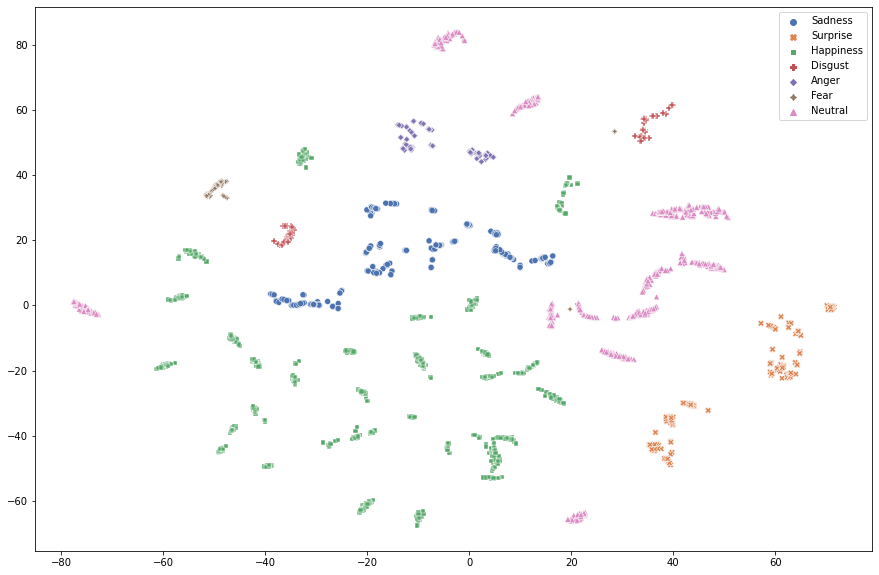

In [55]:
_, _ = visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)

#### Practical test

In [10]:

model = torch.load('exploss_benchamrk_rafdb/resExploss_bridgefeatures_originalRAFDB_resnet50_model.pt')
model = model.to(device)
model.eval()

Resnet50_exp(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [12]:
images, labels = iter(test_loader).next()
images = images.to(device)
labels = labels.to(device)

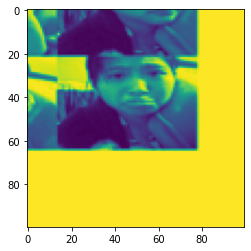

In [16]:
plt.imshow(images[0,0].cpu().numpy())

In [18]:
outputs, _, features = model(images[0].unsqueeze(0), labels[0].unsqueeze(0))
outputs.size()

torch.Size([1, 7])

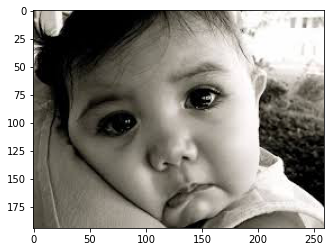

In [32]:
from PIL import Image
import requests
from io import BytesIO

url = 'https://cms.dichthuatabc.com/UploadFile/images/sadness.jpg'
response = requests.get(url)
# img = Image.open(BytesIO(response.content))
image = io.imread(BytesIO(response.content))
plt.imshow(image)

In [37]:
image = test_transforms(image)
image = image.unsqueeze(0)

outputs, _, features = model(images[0].unsqueeze(0), labels[0].unsqueeze(0))


torch.Size([1, 1, 100, 100])

In [24]:
torch.argmax(outputs, dim=1), labels[0]

<ipython-input-24-501fa5809edb>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.argmax(nn.Softmax()(outputs), dim=1), labels[0]


(tensor([4], device='cuda:0'), tensor(4, device='cuda:0'))